## Load

In [1]:
import squigglepy as sq
import numpy as np

from datetime import datetime
from libs import plot_exponential_growth, fmt_worktime
from model_params import doubling_time, reliability_metric, end_year
from model_data import model_data

print("Loaded libraries")

Loaded libraries


## Longer-term METR Predictions

In [2]:
# Generate quarterly METR predictions (PUBLIC MODELS - NO SHIFT)
ref_model = 'gpt5'
reliability_metric_str = {
    'performance_50p': '50%',
    'performance_80p': '80%',
}
baseline_task_length = model_data[ref_model][reliability_metric]
baseline_launch_date = model_data[ref_model]['launch_date']
print(f"METR Task Horizon Predictions ({reliability_metric_str[reliability_metric]} reliability) - PUBLIC MODELS")
print("=" * 70)
print(f"Baseline: GPT5 at {baseline_task_length:.1f}hr on {baseline_launch_date.strftime('%Y-%m-%d')}")
print("=" * 70)
print()


# Define quarters to predict (END of quarter)
def end_of_quarter(year, q):
    if q == 1:
        return datetime(year, 3, 31)
    elif q == 2:
        return datetime(year, 6, 30)
    elif q == 3:
        return datetime(year, 9, 30)
    else:  # q == 4
        return datetime(year, 12, 31)


quarters = []
for year in range(2025, 2031):
    start_q = 4 if year == 2025 else 1
    for q in range(start_q, 5):
        quarters.append((year, q, end_of_quarter(year, q)))

# Sample parameters
n_samples = 50000
tau_samples = sq.sample(doubling_time, n=n_samples)

print(
    f"{'Quarter':<8} {'End Date':<12} {'Mean':<10} {'Median':<10} {'90% CI':<25} {'Days from today'}"
)
print("-" * 85)

results = []
for year, q, quarter_date in quarters:
    days_from_gpt5 = (quarter_date - baseline_launch_date).days

    if days_from_gpt5 < 0:
        continue

    task_lengths = np.zeros(n_samples)
    for i in range(n_samples):
        doublings = days_from_gpt5 / tau_samples[i]
        task_lengths[i] = baseline_task_length * (2**doublings)

    mean_val = np.mean(task_lengths)
    median_val = np.median(task_lengths)
    p5 = np.percentile(task_lengths, 5)
    p95 = np.percentile(task_lengths, 95)

    ci_str = f"[{fmt_worktime(p5)} - {fmt_worktime(p95)}]"
    date_str = quarter_date.strftime("%Y-%m-%d")

    print(
        f"{year}Q{q:<7} {date_str:<12} {fmt_worktime(mean_val):<10} {fmt_worktime(median_val):<10} {ci_str:<25} {days_from_gpt5:>4}"
    )

    results.append(
        {
            "quarter": f"{year}Q{q}",
            "date": quarter_date,
            "mean": mean_val,
            "median": median_val,
            "p5": p5,
            "p95": p95,
            "days": days_from_gpt5,
            "task_lengths": task_lengths,
        }
    )

    if q == 4:
        print()

# Show key milestones
print("\n" + "=" * 70)
print("Key Milestones (Median Estimates) - PUBLIC MODELS")
print("=" * 70)

# Updated milestones using work time
milestones = [
    (2, "2 hours"),
    (4, "4 hours"),
    (8, "1 day"),
    (16, "2 days"),
    (24, "3 days"),
    (40, "1 week"),
    (174, "1 month"),
]

for hours, name in milestones:
    for r in results:
        if r["median"] >= hours:
            prob = np.mean(r["task_lengths"] >= hours) * 100
            date_str = r["date"].strftime("%B %d, %Y")
            print(f"{name:<12} → {r['quarter']} ({date_str}, {prob:.0f}% of samples)")
            break
    else:
        print(f"{name:<12} → Not reached by 2029Q4")

METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS
Baseline: GPT5 at 2.3hr on 2025-08-07

Quarter  End Date     Mean       Median     90% CI                    Days from today
-------------------------------------------------------------------------------------
2025Q4       2025-12-31   4.2hr      4.0hr      [3.1hr - 6.0hr]            146

2026Q1       2026-03-31   6.2hr      5.5hr      [3.8hr - 1.4d]             236
2026Q2       2026-06-30   1.2d       7.8hr      [4.5hr - 2.5d]             327
2026Q3       2026-09-30   1.9d       1.4d       [5.5hr - 4.5d]             419
2026Q4       2026-12-31   3.2d       1.9d       [6.6hr - 1.7wk]            511

2027Q1       2027-03-31   1.1wk      2.7d       [8.0hr - 3.0wk]            601
2027Q2       2027-06-30   2.1wk      3.8d       [1.2d - 1.3mo]             692
2027Q3       2027-09-30   1.0mo      1.1wk      [1.5d - 2.3mo]             784
2027Q4       2027-12-31   2.4mo      1.5wk      [1.8d - 4.2mo]             876

2028Q1     

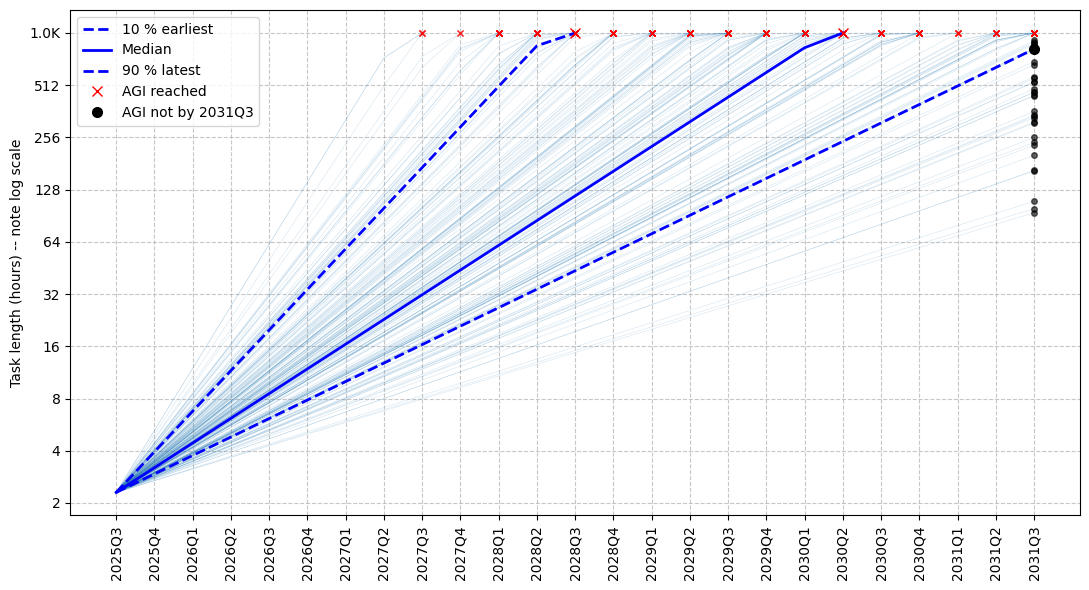

In [3]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    start_hours=baseline_task_length,
    start_date=baseline_launch_date,
    agi_task_length=100_000,
    shift=0,
    n_quarters=24,
    n_samples=100_000,
    n_traces=200,
    max_task_power=10,
)

## Shorter-term predictions

#### Predict Claude 4 Opus

In [4]:
def predict(from_model, for_model, debug=False, verbose=True):
    if isinstance(from_model, str):
        from_model = model_data[from_model]
    if isinstance(for_model, str):
        for_model = model_data[for_model]

    if verbose:
        print(f"PREDICT {from_model['name']} -> {for_model['name']}")
    days_since = (for_model['launch_date'] - from_model['launch_date']).days

    def extrapolation():
        individual_model_idiosyncratic_variation = sq.norm(0.75, 1/0.75, lclip=0.1)
        doublings = days_since / doubling_time
        return from_model['performance_50p'] * (2**doublings) * individual_model_idiosyncratic_variation

    if debug:
        return {'from_model': from_model,
                'for_model': for_model,
                'days_since': days_since,
                'doubling_time': doubling_time,
                'doublings': days_since / doubling_time,
                'from_perf': from_model['performance_50p']}
    else:
        samples = sq.sample(extrapolation, n=50_000, verbose=True)
        mean_ci = sq.get_mean_and_ci(samples, credibility=80)
        if verbose:
            print(f"Predicted: {fmt_worktime(mean_ci['mean'])} (80%CI: {fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
    
        if for_model.get('performance_50p') and verbose:
            print(f"Actual observed: {for_model['name']} at {for_model['performance_50p']:.1f}hr")
        return samples


def multi_predict(from_models, for_model, verbose=True):
    pred_samples = []
    for from_model in from_models:
        pred_samples.append(predict(from_model, for_model, debug=False, verbose=True))
        if verbose:
            print('')
    if verbose:
            print('- MIXED MODEL -')
    pred_samples = np.concatenate(pred_samples)
    mean_ci = sq.get_mean_and_ci(pred_samples, credibility=80)
    
    if verbose:
        print(f"Predicted: {fmt_worktime(mean_ci['mean'])} (80%CI: {fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")

    bins = [0, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7, 99999]
    labels = ['<1.5h', '1.5h - 2h', '2h - 2.5h', '2.5h - 3h', '3h - 3.5h', 
              '3.5h - 4h', '4h - 5h', '5h - 6h', '6h - 7h', '>7h']
    counts, _ = np.histogram(pred_samples, bins=bins)
    percentages = 100 * counts / len(pred_samples)
    if verbose:
        print('')
        for label, pct in zip(labels, percentages):
            print(f"{label} {pct:.1f}%")
            
    if isinstance(for_model, str):
        for_model = model_data[for_model]
    if for_model.get('performance_50p') and verbose:
        print('')
        print(f"Actual observed: {for_model['name']} at {for_model['performance_50p']:.1f}hr")
        
    return pred_samples

_ = multi_predict(from_models=['o3', 'claude_3p7_sonnet', 'claude_3p5_sonnet_new'], for_model='claude_4_opus')

PREDICT o3 -> Claude 4 Opus


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9248.02it/s]


Predicted: 1.9hr (80%CI: 1.5hr - 2.3hr)
Actual observed: Claude 4 Opus at 1.4hr

PREDICT Claude 3.7 Sonnet -> Claude 4 Opus


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9112.50it/s]


Predicted: 1.4hr (80%CI: 1.0hr - 1.8hr)
Actual observed: Claude 4 Opus at 1.4hr

PREDICT Claude 3.5 Sonnet (new) -> Claude 4 Opus


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9287.00it/s]

Predicted: 1.3hr (80%CI: 47min - 1.8hr)
Actual observed: Claude 4 Opus at 1.4hr

- MIXED MODEL -
Predicted: 1.5hr (80%CI: 56min - 2.1hr)

<1.5h 53.3%
1.5h - 2h 31.3%
2h - 2.5h 13.1%
2.5h - 3h 1.8%
3h - 3.5h 0.3%
3.5h - 4h 0.1%
4h - 5h 0.1%
5h - 6h 0.0%
6h - 7h 0.0%
>7h 0.0%

Actual observed: Claude 4 Opus at 1.4hr


#### Predict GPT5

In [5]:
_ = multi_predict(from_models=['o1', 'o3'], for_model='gpt5')

PREDICT o1 -> GPT5


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9160.59it/s]


Predicted: 2.0hr (80%CI: 1.2hr - 3.0hr)
Actual observed: GPT5 at 2.3hr

PREDICT o3 -> GPT5


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9238.69it/s]


Predicted: 2.6hr (80%CI: 1.9hr - 3.4hr)
Actual observed: GPT5 at 2.3hr

- MIXED MODEL -
Predicted: 2.3hr (80%CI: 1.3hr - 3.3hr)

<1.5h 16.5%
1.5h - 2h 23.0%
2h - 2.5h 25.7%
2.5h - 3h 18.6%
3h - 3.5h 9.0%
3.5h - 4h 3.7%
4h - 5h 2.4%
5h - 6h 0.5%
6h - 7h 0.2%
>7h 0.3%

Actual observed: GPT5 at 2.3hr


#### Predict Claude 4.5 Sonnet

In [6]:
_ = multi_predict(from_models=['gpt5', 'claude_4_opus', 'claude_4p1_opus'], for_model='claude_4p5_sonnet')

PREDICT GPT5 -> Claude 4.5 Sonnet


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9244.19it/s]


Predicted: 3.0hr (80%CI: 2.3hr - 3.7hr)
Actual observed: Claude 4.5 Sonnet at 2.0hr

PREDICT Claude 4 Opus -> Claude 4.5 Sonnet


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9155.03it/s]


Predicted: 2.5hr (80%CI: 1.8hr - 3.4hr)
Actual observed: Claude 4.5 Sonnet at 2.0hr

PREDICT Claude 4.1 Opus -> Claude 4.5 Sonnet


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9251.81it/s]

Predicted: 2.5hr (80%CI: 1.9hr - 3.1hr)
Actual observed: Claude 4.5 Sonnet at 2.0hr

- MIXED MODEL -
Predicted: 2.7hr (80%CI: 1.9hr - 3.4hr)

<1.5h 1.3%
1.5h - 2h 11.7%
2h - 2.5h 29.9%
2.5h - 3h 31.1%
3h - 3.5h 17.4%
3.5h - 4h 6.1%
4h - 5h 2.2%
5h - 6h 0.2%
6h - 7h 0.0%
>7h 0.0%

Actual observed: Claude 4.5 Sonnet at 2.0hr


#### Predict GPT5.1-Codex-Max

In [7]:
_ = multi_predict(from_models=['o1', 'gpt5'], for_model='gpt5.1-codex-max')

PREDICT o1 -> GPT5.1-Codex-Max


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9188.46it/s]


Predicted: 3.3hr (80%CI: 1.5hr - 5.5hr)
Actual observed: GPT5.1-Codex-Max at 2.9hr

PREDICT GPT5 -> GPT5.1-Codex-Max


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9280.41it/s]

Predicted: 3.6hr (80%CI: 2.7hr - 4.7hr)
Actual observed: GPT5.1-Codex-Max at 2.9hr

- MIXED MODEL -
Predicted: 3.5hr (80%CI: 1.8hr - 5.0hr)

<1.5h 4.6%
1.5h - 2h 9.9%
2h - 2.5h 12.0%
2.5h - 3h 15.4%
3h - 3.5h 17.6%
3.5h - 4h 15.2%
4h - 5h 15.6%
5h - 6h 4.8%
6h - 7h 1.9%
>7h 2.9%

Actual observed: GPT5.1-Codex-Max at 2.9hr


#### Predict Gemini 3

In [8]:
_ = multi_predict(from_models=['gpt5', 'claude_4_opus', 'gemini_2p5_pro'], for_model='gemini_3')

PREDICT GPT5 -> Gemini 3


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9294.42it/s]


Predicted: 3.6hr (80%CI: 2.7hr - 4.7hr)

PREDICT Claude 4 Opus -> Gemini 3


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9141.03it/s]


Predicted: 3.2hr (80%CI: 2.1hr - 4.4hr)

PREDICT Gemini 2.5 Pro -> Gemini 3


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9227.43it/s]


Predicted: 1.4hr (80%CI: 55min - 1.9hr)

- MIXED MODEL -
Predicted: 2.7hr (80%CI: 1.1hr - 4.3hr)

<1.5h 23.6%
1.5h - 2h 10.0%
2h - 2.5h 10.4%
2.5h - 3h 14.2%
3h - 3.5h 14.9%
3.5h - 4h 11.9%
4h - 5h 11.0%
5h - 6h 2.8%
6h - 7h 0.8%
>7h 0.5%


#### Predict Claude 4.5 Opus

In [9]:
_ = multi_predict(from_models=['gpt5.1-codex-max', 'claude_4_opus', 'claude_4p1_opus', 'claude_4p5_sonnet'], for_model='claude_4p5_opus')

PREDICT GPT5.1-Codex-Max -> Claude 4.5 Opus


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9141.08it/s]


Predicted: 3.1hr (80%CI: 2.4hr - 3.7hr)

PREDICT Claude 4 Opus -> Claude 4.5 Opus


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9193.83it/s]


Predicted: 3.2hr (80%CI: 2.1hr - 4.6hr)

PREDICT Claude 4.1 Opus -> Claude 4.5 Opus


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9303.46it/s]


Predicted: 3.1hr (80%CI: 2.3hr - 4.1hr)

PREDICT Claude 4.5 Sonnet -> Claude 4.5 Opus


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9186.25it/s]

Predicted: 2.6hr (80%CI: 2.0hr - 3.3hr)

- MIXED MODEL -
Predicted: 3.0hr (80%CI: 2.2hr - 3.9hr)

<1.5h 0.5%
1.5h - 2h 5.0%
2h - 2.5h 19.6%
2.5h - 3h 30.5%
3h - 3.5h 24.3%
3.5h - 4h 11.7%
4h - 5h 6.2%
5h - 6h 1.4%
6h - 7h 0.5%
>7h 0.4%


#### Predict GPT5.2

In [10]:
_ = multi_predict(from_models=['gpt5', 'gpt5.1-codex-max', 'claude_4p1_opus'], for_model='gpt5.2')

PREDICT GPT5 -> GPT5.2


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9262.51it/s]


Predicted: 4.0hr (80%CI: 2.8hr - 5.3hr)

PREDICT GPT5.1-Codex-Max -> GPT5.2


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9232.16it/s]


Predicted: 3.3hr (80%CI: 2.6hr - 4.0hr)

PREDICT Claude 4.1 Opus -> GPT5.2


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9345.79it/s]

Predicted: 3.3hr (80%CI: 2.4hr - 4.4hr)

- MIXED MODEL -
Predicted: 3.5hr (80%CI: 2.5hr - 4.7hr)

<1.5h 0.1%
1.5h - 2h 1.3%
2h - 2.5h 7.5%
2.5h - 3h 19.3%
3h - 3.5h 26.3%
3.5h - 4h 21.3%
4h - 5h 17.7%
5h - 6h 4.4%
6h - 7h 1.3%
>7h 0.7%


#### Predict today

In [12]:
today = {'name': 'TODAY', 'launch_date': datetime.now()}
_ = multi_predict(from_models=['gpt5', 'gpt5.1-codex-max', 'claude_4p1_opus'], for_model=today)

PREDICT GPT5 -> TODAY


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9252.38it/s]


Predicted: 4.1hr (80%CI: 2.9hr - 5.5hr)

PREDICT GPT5.1-Codex-Max -> TODAY


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9178.24it/s]


Predicted: 3.4hr (80%CI: 2.6hr - 4.1hr)

PREDICT Claude 4.1 Opus -> TODAY


100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9217.90it/s]


Predicted: 3.4hr (80%CI: 2.4hr - 4.6hr)

- MIXED MODEL -
Predicted: 3.6hr (80%CI: 2.6hr - 4.8hr)

<1.5h 0.1%
1.5h - 2h 1.1%
2h - 2.5h 6.3%
2.5h - 3h 17.2%
3h - 3.5h 25.2%
3.5h - 4h 22.1%
4h - 5h 20.0%
5h - 6h 5.4%
6h - 7h 1.7%
>7h 1.0%
